In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

from splines import PenalizedSpline
from gam import GAM, LogisticGAM
from data_utils import load_fev_data, load_heart_data, get_fev_data_summary, get_heart_data_summary
from utils import (
    mean_squared_error, 
    r_squared, 
    root_mean_squared_error,
    classification_metrics,
    plot_roc_curve,
    plot_calibration_curve,
    plot_confusion_matrix,
    plot_qq_plot
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

np.random.seed(42)

# 1. Penalized Splines (P-splines)

## Advanced Splines with the FEV Dataset

This section replaces synthetic visualizations with a data-driven exploration using the FEV lung function dataset.

## Dataset Overview

We use `fev.csv`, which records forced expiratory volume (FEV) alongside demographic attributes. The helper in `data_utils.py` handles encoding of categorical columns.

In [2]:
X_train, X_test, y_train, y_test, feature_info = load_fev_data(
    filepath='fev.csv',
    standardize=True,
    test_size=0.2,
    random_state=42
)

feature_names = feature_info['feature'].tolist()
train_df = pd.DataFrame(X_train, columns=feature_names)
train_df['fev'] = y_train

print('Training summary (selected statistics):')
print(train_df.describe().T[['mean', 'std', 'min', 'max']].round(3))
print('\nFeature metadata:')
print(feature_info.to_string(index=False))

Training summary (selected statistics):
         mean    std    min    max
age    -0.000  1.001 -2.434  3.179
height -0.000  1.001 -2.586  2.261
sex     0.505  0.500  0.000  1.000
smoke   0.901  0.300  0.000  1.000
fev     2.620  0.857  0.791  5.638

Feature metadata:
feature        type                               description
    age  continuous                              Age in years
 height  continuous                          Height in inches
    sex categorical                 Gender (1=male, 0=female)
  smoke categorical Smoking status (1=non-current, 0=current)


## Penalized Spline: Age vs FEV

A penalized cubic spline captures the nonlinear relationship between age and lung capacity. We select the smoothing parameter via 5-fold cross-validation.

In [3]:
age_train = X_train[:, 0]
age_test = X_test[:, 0]

lambdas = np.logspace(-3, 2, 15)
template_model = PenalizedSpline(n_knots=20, degree=3, lambda_=1.0, diff_order=2)
best_lambda, cv_errors = template_model.cross_validate(age_train, y_train, lambdas, cv_folds=5)

pspline = PenalizedSpline(n_knots=20, degree=3, lambda_=best_lambda, diff_order=2)
pspline.fit(age_train, y_train)

train_pred = pspline.predict(age_train)
test_pred = pspline.predict(age_test)

train_rmse = root_mean_squared_error(y_train, train_pred)
test_rmse = root_mean_squared_error(y_test, test_pred)

cv_table = pd.DataFrame({
    'lambda': lambdas,
    'cv_error': cv_errors
}).sort_values('cv_error').reset_index(drop=True)

print(f'Selected lambda: {best_lambda:.4f}')
print(f'Effective degrees of freedom: {pspline.effective_df():.2f}')
print(f'Train RMSE: {train_rmse:.3f}')
print(f'Test RMSE: {test_rmse:.3f}')
print('\nTop cross-validation configurations:')
print(cv_table.head(5).to_string(index=False))

preview = pd.DataFrame({
    'age': age_test,
    'actual_fev': y_test,
    'predicted_fev': test_pred
}).round(3).head(5)
print('\nSample test predictions:')
print(preview.to_string(index=False))

Selected lambda: 100.0000
Effective degrees of freedom: 5.71
Train RMSE: 0.552
Test RMSE: 0.550

Top cross-validation configurations:
    lambda  cv_error
100.000000  6.133033
 43.939706  6.133798
 19.306977  6.134287
  8.483429  6.134686
  3.727594  6.135047

Sample test predictions:
   age  actual_fev  predicted_fev
 0.021       3.111          2.671
-0.329       3.842          2.382
 0.021       4.591          2.671
-1.031       2.564          1.874
 1.425       4.683          3.511


## Visualizing the Penalized Spline Fit

Let's visualize how well our penalized spline captures the relationship between age and FEV.

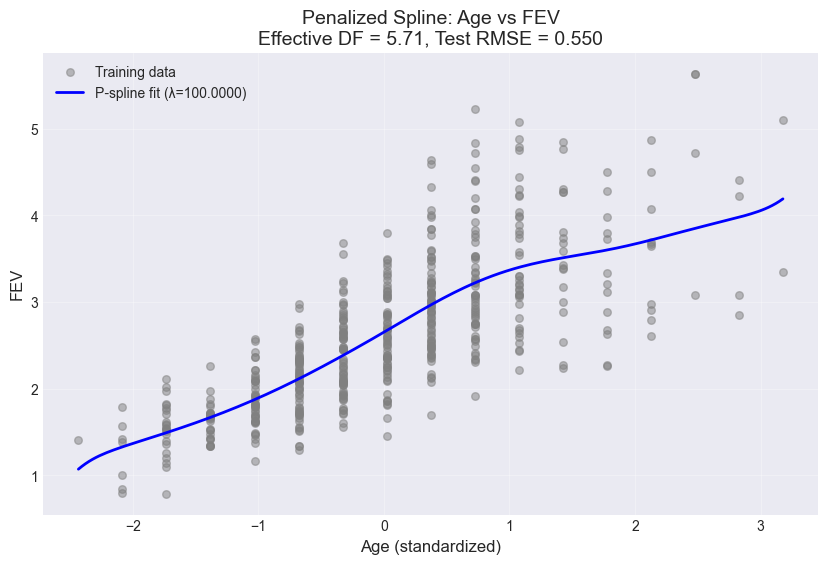

In [4]:
age_grid = np.linspace(age_train.min(), age_train.max(), 200)
fev_pred_grid = pspline.predict(age_grid)

plt.figure(figsize=(10, 6))
plt.scatter(age_train, y_train, alpha=0.5, s=30, label='Training data', color='gray')
plt.plot(age_grid, fev_pred_grid, 'b-', linewidth=2, label=f'P-spline fit (λ={best_lambda:.4f})')
plt.xlabel('Age (standardized)', fontsize=12)
plt.ylabel('FEV', fontsize=12)
plt.title(f'Penalized Spline: Age vs FEV\nEffective DF = {pspline.effective_df():.2f}, Test RMSE = {test_rmse:.3f}', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Generalized Additive Models for Regression

**Generalized Additive Models (GAMs)** extend linear models by allowing non-linear relationships:

$$E(Y \mid X) = \beta_0 + f_1(X_1) + f_2(X_2) + \cdots + f_p(X_p)$$

where $f_j$ are smooth functions estimated using penalized splines.

**Key Properties**:
- **Additivity**: Each predictor contributes independently (interpretable)
- **Flexibility**: Captures non-linear patterns automatically
- **Backfitting Algorithm**: Iteratively estimates each $f_j$ given others
- **Effective Degrees of Freedom**: Quantifies model complexity

## Data Exploration

### Dataset: FEV (Forced Expiratory Volume)

**Objective**: Predict lung function (FEV) from demographic and behavioral variables.

**Variables**:
- **FEV** (response): Forced expiratory volume in liters (continuous)
- **Age**: Age in years (expect non-linear growth pattern)
- **Height**: Height in inches (expect linear relationship)
- **Sex**: Male (1) or Female (0)
- **Smoke**: Smoker (1) or Non-smoker (0)

**Sample Size**: 654 observations

In [5]:
X_train, X_test, y_train, y_test, features = load_fev_data(
    filepath='fev.csv',
    standardize=True,
    test_size=0.2,
    random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nFeatures:\n{features}")

summary = get_fev_data_summary('fev.csv')
print(f"\nDataset Summary:\n{summary}")

Training set: (523, 4)
Test set: (131, 4)

Features:
  feature         type                                description
0     age   continuous                               Age in years
1  height   continuous                           Height in inches
2     sex  categorical                  Gender (1=male, 0=female)
3   smoke  categorical  Smoking status (1=non-current, 0=current)

Dataset Summary:
                           age         fev      height
count               654.000000  654.000000  654.000000
mean                  9.931193    2.636780   61.143578
std                   2.953935    0.867059    5.703513
min                   3.000000    0.791000   46.000000
25%                   8.000000    1.981000   57.000000
50%                  10.000000    2.547500   61.500000
75%                  12.000000    3.118500   65.500000
max                  19.000000    5.793000   74.000000
missing               0.000000    0.000000    0.000000
sex: female         318.000000  318.000000  318.0

/var/folders/qt/d3mbxc4x72b2dl1r4f452vy00000gn/T/ipykernel_60693/490445640.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df[df['sex'] == 0]['fev'], df[df['sex'] == 1]['fev']],
/var/folders/qt/d3mbxc4x72b2dl1r4f452vy00000gn/T/ipykernel_60693/490445640.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([df[df['smoke'] == 0]['fev'], df[df['smoke'] == 1]['fev']],


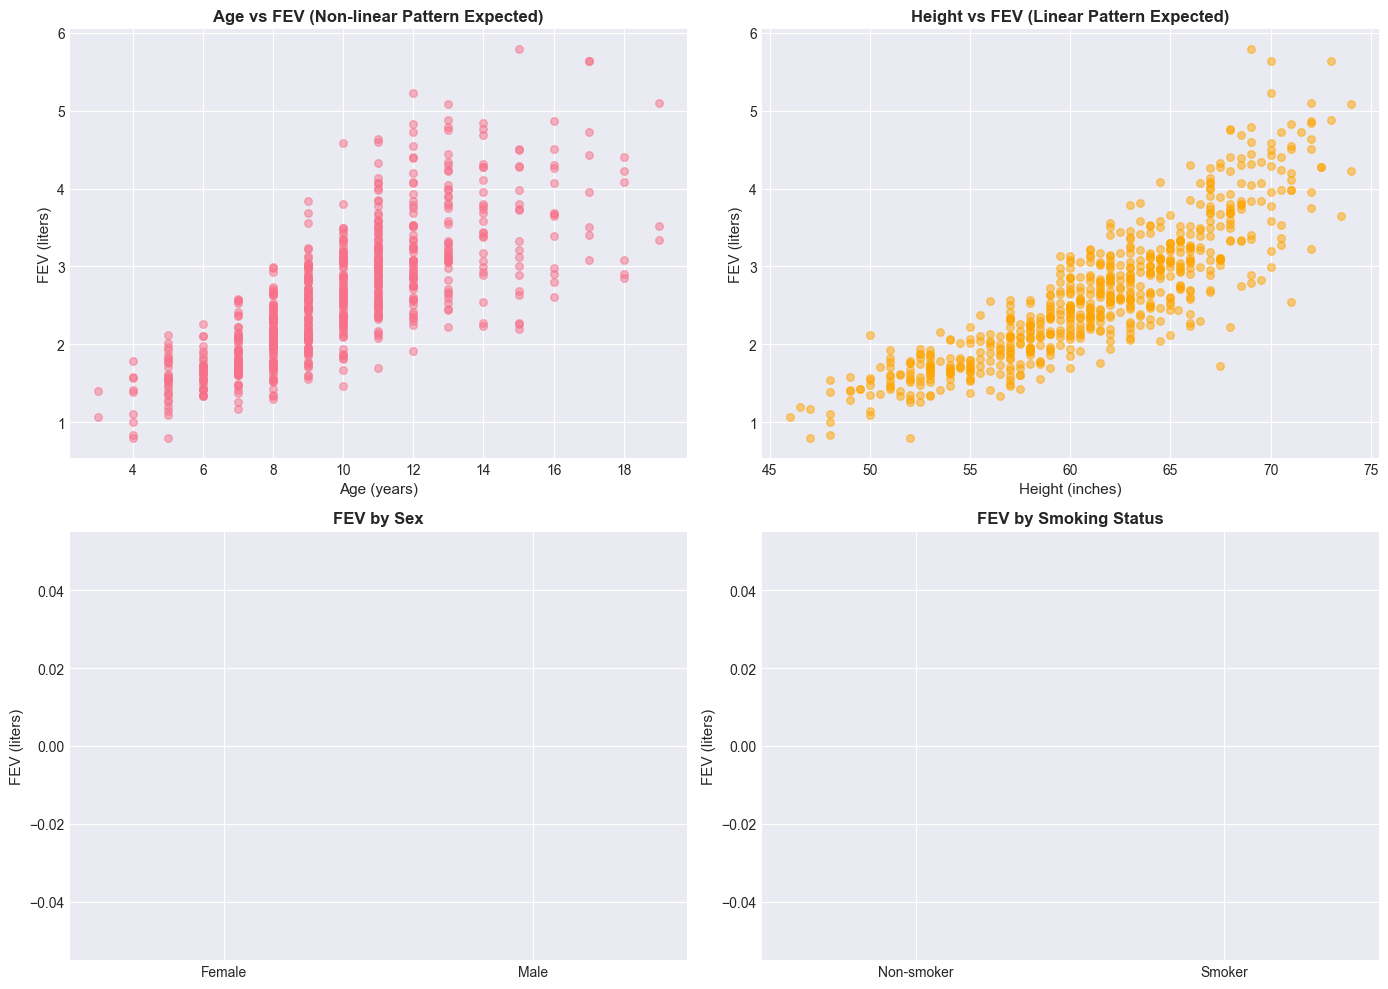

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df = pd.read_csv('fev.csv')

axes[0, 0].scatter(df['age'], df['fev'], alpha=0.5, s=30)
axes[0, 0].set_xlabel('Age (years)', fontsize=11)
axes[0, 0].set_ylabel('FEV (liters)', fontsize=11)
axes[0, 0].set_title('Age vs FEV (Non-linear Pattern Expected)', fontweight='bold')

axes[0, 1].scatter(df['height'], df['fev'], alpha=0.5, s=30, color='orange')
axes[0, 1].set_xlabel('Height (inches)', fontsize=11)
axes[0, 1].set_ylabel('FEV (liters)', fontsize=11)
axes[0, 1].set_title('Height vs FEV (Linear Pattern Expected)', fontweight='bold')

axes[1, 0].boxplot([df[df['sex'] == 0]['fev'], df[df['sex'] == 1]['fev']], 
                    labels=['Female', 'Male'])
axes[1, 0].set_ylabel('FEV (liters)', fontsize=11)
axes[1, 0].set_title('FEV by Sex', fontweight='bold')

axes[1, 1].boxplot([df[df['smoke'] == 0]['fev'], df[df['smoke'] == 1]['fev']], 
                    labels=['Non-smoker', 'Smoker'])
axes[1, 1].set_ylabel('FEV (liters)', fontsize=11)
axes[1, 1].set_title('FEV by Smoking Status', fontweight='bold')

plt.tight_layout()
plt.show()

## Baseline: Linear Regression Model

First, fit a standard linear regression for comparison:

$$\text{FEV} = \beta_0 + \beta_1 \cdot \text{Age} + \beta_2 \cdot \text{Height} + \beta_3 \cdot \text{Sex} + \beta_4 \cdot \text{Smoke} + \epsilon$

In [7]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred_train_lm = lm.predict(X_train)
y_pred_test_lm = lm.predict(X_test)

train_mse_lm = mean_squared_error(y_train, y_pred_train_lm)
train_r2_lm = r_squared(y_train, y_pred_train_lm)
test_mse_lm = mean_squared_error(y_test, y_pred_test_lm)
test_r2_lm = r_squared(y_test, y_pred_test_lm)

print("Linear Regression Results:")
print("=" * 50)
print(f"Training:   MSE = {train_mse_lm:.4f},  R² = {train_r2_lm:.3f}")
print(f"Test:       MSE = {test_mse_lm:.4f},  R² = {test_r2_lm:.3f}")
print(f"\nCoefficients:")
for i, feat in enumerate(features['feature']):
    print(f"  {feat:10s}: {lm.coef_[i]:7.3f}")
print(f"  Intercept : {lm.intercept_:7.3f}")

Linear Regression Results:
Training:   MSE = 0.1716,  R² = 0.766
Test:       MSE = 0.1590,  R² = 0.806

Coefficients:
  age       :   0.180
  height    :   0.590
  sex       :   0.151
  smoke     :   0.065
  Intercept :   2.485


## Generalized Additive Model (GAM)

### Model Specification

We'll fit a GAM with:
- **Smooth terms**: Age, Height (using P-splines with 10 knots)
- **Linear terms**: Sex, Smoke (binary variables)
- **Smoothing parameter**: λ = 1.0 (controls wiggliness)

$$E(\text{FEV} \mid X) = \beta_0 + f_1(\text{Age}) + f_2(\text{Height}) + \beta_3 \cdot \text{Sex} + \beta_4 \cdot \text{Smoke}$$

The backfitting algorithm iterates:
1. Initialize all functions to 0
2. For each $f_j$: update using partial residuals $r_j = y - \hat{\beta}_0 - \sum_{k \neq j} \hat{f}_k(x_k)$
3. Repeat until convergence

In [8]:
gam = GAM(
    smooth_features=[0, 1],
    linear_features=[2, 3],
    n_knots=[10, 10],
    lambda_=[1.0, 1.0],
    degree=3,
    max_iter=100,
    tol=1e-4
)

print("Fitting GAM...\n")
gam.fit(X_train, y_train, verbose=True)

y_pred_train_gam = gam.predict(X_train)
y_pred_test_gam = gam.predict(X_test)

train_mse_gam = mean_squared_error(y_train, y_pred_train_gam)
train_r2_gam = r_squared(y_train, y_pred_train_gam)
test_mse_gam = mean_squared_error(y_test, y_pred_test_gam)
test_r2_gam = r_squared(y_test, y_pred_test_gam)

print("\n" + "=" * 50)
print("GAM Results:")
print("=" * 50)
print(f"Training:   MSE = {train_mse_gam:.4f},  R² = {train_r2_gam:.3f}")
print(f"Test:       MSE = {test_mse_gam:.4f},  R² = {test_r2_gam:.3f}")

Fitting GAM...

Iteration 1: Change = 0.000000
Converged after 1 iterations

GAM Results:
Training:   MSE = 0.6052,  R² = 0.174
Test:       MSE = 0.6263,  R² = 0.234


## Model Comparison

Compare Linear Model vs GAM performance and complexity.

In [9]:
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'GAM'],
    'Train MSE': [train_mse_lm, train_mse_gam],
    'Test MSE': [test_mse_lm, test_mse_gam],
    'Train R²': [train_r2_lm, train_r2_gam],
    'Test R²': [test_r2_lm, test_r2_gam],
    'Effective DF': [5, gam.summary()['total_edf']]
})

print("\nModel Comparison:")
print("=" * 80)
print(comparison.to_string(index=False))

if test_r2_gam > test_r2_lm:
    improvement = ((test_r2_gam - test_r2_lm) / test_r2_lm) * 100
    print(f"GAM improves test R² by {improvement:.1f}% over linear model")
else:
    print("Linear model is competitive (data may be approximately linear)")

print(f"GAM uses {gam.summary()['total_edf']:.1f} effective DF (vs 5 for linear model)")


Model Comparison:
            Model  Train MSE  Test MSE  Train R²  Test R²  Effective DF
Linear Regression   0.171560  0.158983  0.765766 0.805612       5.00000
              GAM   0.605206  0.626344  0.173702 0.234171      21.06997
Linear model is competitive (data may be approximately linear)
GAM uses 21.1 effective DF (vs 5 for linear model)


## Model Interpretation: Smooth Functions

Visualize the estimated smooth functions $f_j(x_j)$ to understand how each predictor affects FEV.

In [10]:
summary = gam.summary()

print("GAM Model Summary:")
print("=" * 50)
print(f"Intercept: {summary['intercept']:.3f}")
print(f"Total Effective DF: {summary['total_edf']:.1f}\n")

print("Smooth Terms:")
for feat_idx, info in summary['smooth_terms'].items():
    feat_name = features['feature'].values[feat_idx]
    print(f"  {feat_name:10s}: edf = {info['edf']:.2f}, λ = {info['lambda']}")

print("\nLinear Terms:")
for feat_idx, info in summary['linear_terms'].items():
    feat_name = features['feature'].values[feat_idx]
    print(f"  {feat_name:10s}: coef = {info['coefficient']:.3f}")

GAM Model Summary:
Intercept: 2.620
Total Effective DF: 21.1

Smooth Terms:
  age       : edf = 8.91, λ = 1.0
  height    : edf = 9.16, λ = 1.0

Linear Terms:
  sex       : coef = 0.437
  smoke     : coef = -0.294


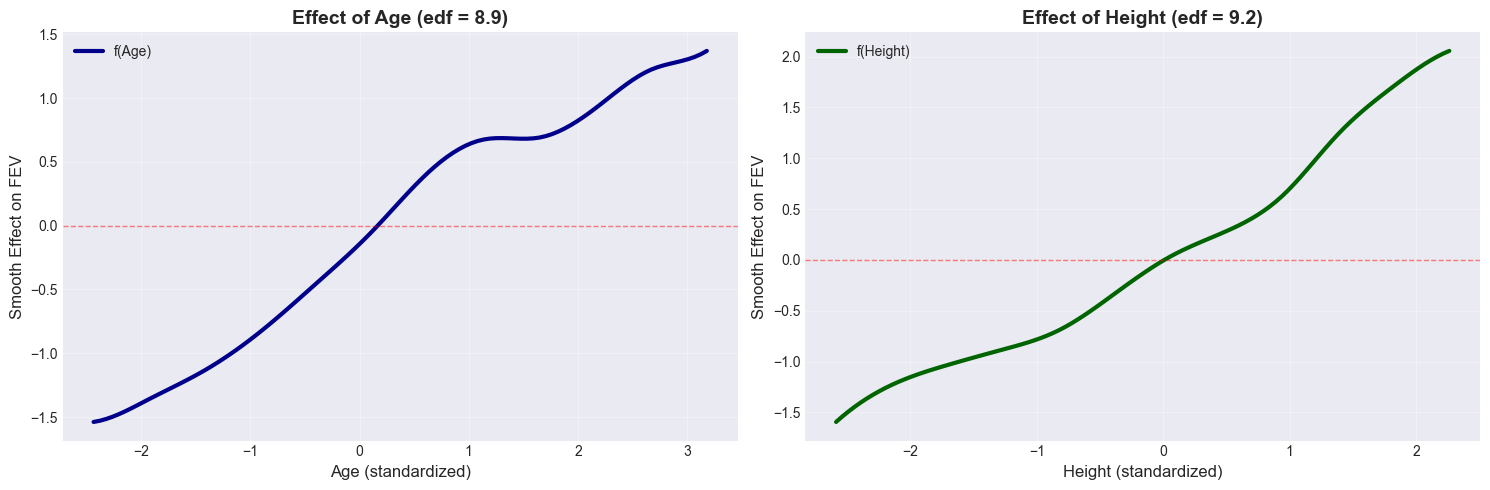


Interpretation of Smooth Functions:

1. Age Effect:
Non-linear relationship detected (edf > 2)
Likely shows growth curve: rapid increase in childhood, plateau in adolescence

2. Height Effect:
Non-linear relationship detected (edf > 2)

3. Categorical Effects:
sex: increases FEV by 0.437 liters
smoke: decreases FEV by 0.294 liters


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

x_age, f_age = gam.get_smooth_function(0, n_points=100)
axes[0].plot(x_age, f_age, linewidth=3, color='darkblue', label='f(Age)')
axes[0].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Age (standardized)', fontsize=12)
axes[0].set_ylabel('Smooth Effect on FEV', fontsize=12)
axes[0].set_title(f'Effect of Age (edf = {summary["smooth_terms"][0]["edf"]:.1f})', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

x_height, f_height = gam.get_smooth_function(1, n_points=100)
axes[1].plot(x_height, f_height, linewidth=3, color='darkgreen', label='f(Height)')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Height (standardized)', fontsize=12)
axes[1].set_ylabel('Smooth Effect on FEV', fontsize=12)
axes[1].set_title(f'Effect of Height (edf = {summary["smooth_terms"][1]["edf"]:.1f})', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nInterpretation of Smooth Functions:")
print("\n1. Age Effect:")
if summary['smooth_terms'][0]['edf'] > 2:
    print("Non-linear relationship detected (edf > 2)")
    print("Likely shows growth curve: rapid increase in childhood, plateau in adolescence")
else:
    print("Nearly linear relationship (edf ≈ 1-2)")

print("\n2. Height Effect:")
if summary['smooth_terms'][1]['edf'] > 2:
    print("Non-linear relationship detected (edf > 2)")
else:
    print("Approximately linear relationship (edf ≈ 1-2)")
    print("As expected: taller individuals tend to have higher lung capacity")

print(f"\n3. Categorical Effects:")
for feat_idx, info in summary['linear_terms'].items():
    feat_name = features['feature'].values[feat_idx]
    direction = "increases" if info['coefficient'] > 0 else "decreases"
    print(f"{feat_name}: {direction} FEV by {abs(info['coefficient']):.3f} liters")

## Model Diagnostics

Check residual patterns to assess model fit.

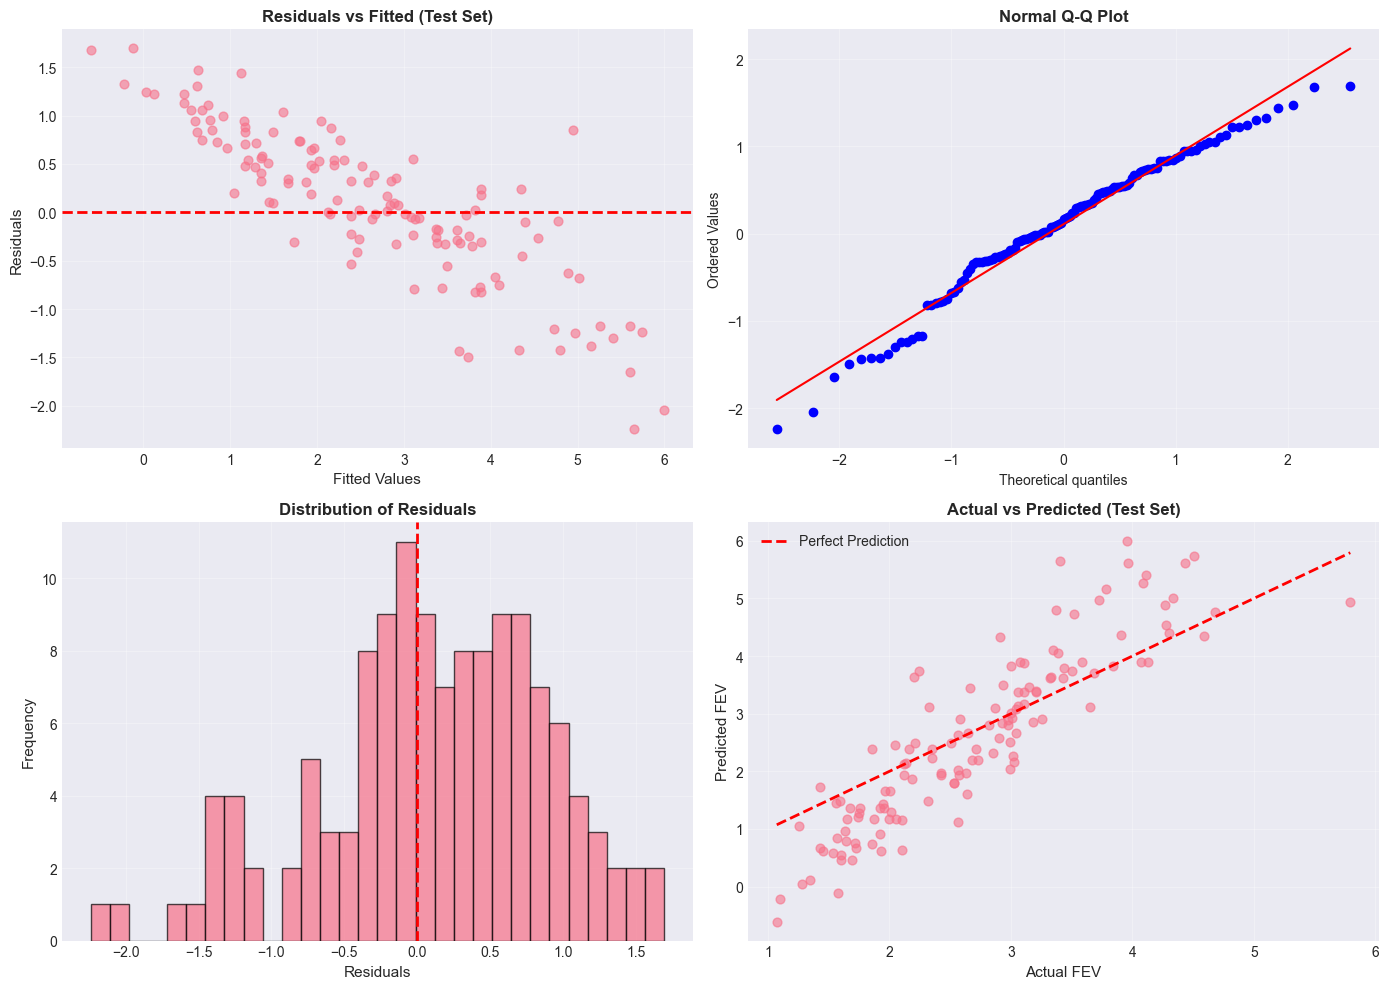


Residual Diagnostics:
Mean:      0.1075  (should be ≈ 0)
Std Dev:   0.7841
Skewness:  -0.5340  (should be ≈ 0 for normality)
Kurtosis:  0.0895  (should be ≈ 0 for normality)

Shapiro-Wilk Test: p = 0.0212
Residuals deviate from normality (p < 0.05)


In [12]:
residuals_train_gam = y_train - y_pred_train_gam
residuals_test_gam = y_test - y_pred_test_gam

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_pred_test_gam, residuals_test_gam, alpha=0.6, s=40)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Residuals vs Fitted (Test Set)', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuals_test_gam, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(residuals_test_gam, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Residuals', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test, y_pred_test_gam, alpha=0.6, s=40)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual FEV', fontsize=11)
axes[1, 1].set_ylabel('Predicted FEV', fontsize=11)
axes[1, 1].set_title('Actual vs Predicted (Test Set)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResidual Diagnostics:")
print("=" * 50)
print(f"Mean:      {np.mean(residuals_test_gam):.4f}  (should be ≈ 0)")
print(f"Std Dev:   {np.std(residuals_test_gam):.4f}")
print(f"Skewness:  {stats.skew(residuals_test_gam):.4f}  (should be ≈ 0 for normality)")
print(f"Kurtosis:  {stats.kurtosis(residuals_test_gam):.4f}  (should be ≈ 0 for normality)")

_, p_value = stats.shapiro(residuals_test_gam)
print(f"\nShapiro-Wilk Test: p = {p_value:.4f}")
if p_value > 0.05:
    print("Residuals appear normally distributed (p > 0.05)")
else:
    print("Residuals deviate from normality (p < 0.05)")

## Smoothing Parameter Selection

Explore how the smoothing parameter λ affects model fit and complexity.


Smoothing Parameter Comparison:
 Lambda  Test MSE  Test R²  Effective DF
   0.01  0.656588 0.197192     30.137508
   0.10  0.626584 0.233877     26.899255
   1.00  0.626344 0.234171     21.069970
  10.00  0.636203 0.222117     15.225474
 100.00  0.662392 0.190095     10.870819

Optimal λ = 1.0 (minimizes test MSE)


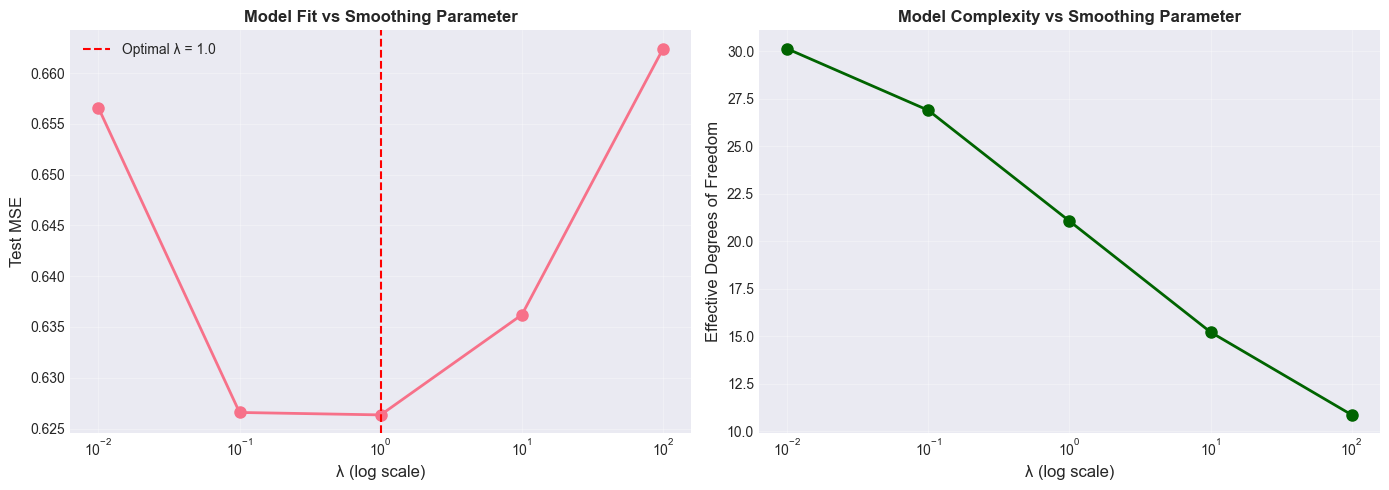

Optimal balance at λ = 1.0


In [13]:
lambdas_to_test = [0.01, 0.1, 1.0, 10.0, 100.0]
results = []

for lam in lambdas_to_test:
    gam_temp = GAM(
        smooth_features=[0, 1],
        linear_features=[2, 3],
        n_knots=[10, 10],
        lambda_=[lam, lam],
        degree=3,
        max_iter=100,
        tol=1e-4
    )
    gam_temp.fit(X_train, y_train, verbose=False)
    
    y_pred_test_temp = gam_temp.predict(X_test)
    test_mse_temp = mean_squared_error(y_test, y_pred_test_temp)
    test_r2_temp = r_squared(y_test, y_pred_test_temp)
    edf_temp = gam_temp.summary()['total_edf']
    
    results.append({
        'Lambda': lam,
        'Test MSE': test_mse_temp,
        'Test R²': test_r2_temp,
        'Effective DF': edf_temp
    })

results_df = pd.DataFrame(results)
print("\nSmoothing Parameter Comparison:")
print("=" * 60)
print(results_df.to_string(index=False))

best_idx = results_df['Test MSE'].idxmin()
best_lambda = results_df.loc[best_idx, 'Lambda']
print(f"\nOptimal λ = {best_lambda} (minimizes test MSE)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].semilogx(results_df['Lambda'], results_df['Test MSE'], 'o-', linewidth=2, markersize=8)
axes[0].axvline(best_lambda, color='red', linestyle='--', label=f'Optimal λ = {best_lambda}')
axes[0].set_xlabel('λ (log scale)', fontsize=12)
axes[0].set_ylabel('Test MSE', fontsize=12)
axes[0].set_title('Model Fit vs Smoothing Parameter', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].semilogx(results_df['Lambda'], results_df['Effective DF'], 'o-', 
                 linewidth=2, markersize=8, color='darkgreen')
axes[1].set_xlabel('λ (log scale)', fontsize=12)
axes[1].set_ylabel('Effective Degrees of Freedom', fontsize=12)
axes[1].set_title('Model Complexity vs Smoothing Parameter', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"Optimal balance at λ = {best_lambda}")

# 3. Logistic Generalized Additive Models for Classification

**Logistic GAM** extends logistic regression with smooth functions:

$$\log\left(\frac{P(Y=1 \mid X)}{1 - P(Y=1 \mid X)}\right) = \beta_0 + f_1(X_1) + f_2(X_2) + \cdots + f_p(X_p)$$

**Estimation**: Iteratively Reweighted Least Squares (IRLS) with backfitting
1. Compute working weights: $w_i = p_i(1 - p_i)$
2. Compute working response: $z_i = \eta_i + \frac{y_i - p_i}{w_i}$
3. Weighted backfitting on $(z, w)$
4. Update predictions and check deviance convergence

where $\eta_i = \log(p_i / (1-p_i))$ is the log-odds (linear predictor).

**Key Advantages**:
- Captures non-linear risk relationships
- Interpretable on probability and log-odds scales
- Regularization prevents overfitting

## Data Exploration

### Dataset: South African Heart Disease Study

**Objective**: Predict coronary heart disease (CHD) from risk factors.

**Variables**:
- **CHD** (response): 0 = No CHD, 1 = CHD present (binary)
- **sbp**: Systolic blood pressure (continuous)
- **tobacco**: Cumulative tobacco consumption in kg (continuous)
- **ldl**: Low-density lipoprotein cholesterol (continuous)
- **adiposity**: Adiposity index (continuous)
- **famhist**: Family history of heart disease (binary: 0=Absent, 1=Present)
- **typea**: Type A behavior score (continuous)
- **obesity**: Obesity measure (continuous)
- **alcohol**: Current alcohol consumption (continuous)
- **age**: Age in years (continuous)

**Sample Size**: 461 observations

In [14]:
X_train, X_test, y_train, y_test, features = load_heart_data(
    filepath='Heart.csv',
    standardize=True,
    test_size=0.2,
    random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nFeatures:\n{features}")

print(f"\nClass Distribution:")
print(f"  Training: {np.sum(y_train==0)} No CHD, {np.sum(y_train==1)} CHD")
print(f"  Test:     {np.sum(y_test==0)} No CHD, {np.sum(y_test==1)} CHD")
print(f"\nCHD Prevalence: {np.mean(y_train)*100:.1f}% (training)")

summary = get_heart_data_summary('Heart.csv')
print(f"\nDataset Summary:\n{summary}")

Training set: (369, 9)
Test set: (93, 9)

Features:
     feature         type                           description
0        sbp   continuous               Systolic blood pressure
1    tobacco   continuous               Cumulative tobacco (kg)
2        ldl   continuous                       LDL cholesterol
3  adiposity   continuous                       Adiposity index
4      typea   continuous                 Type-A behavior score
5    obesity   continuous                         Obesity index
6    alcohol   continuous                   Alcohol consumption
7        age   continuous                           Age (years)
8    famhist  categorical  Family history (1=Present, 0=Absent)

Class Distribution:
  Training: 241 No CHD, 128 CHD
  Test:     61 No CHD, 32 CHD

CHD Prevalence: 34.7% (training)

Dataset Summary:
                        sbp     tobacco         ldl   adiposity       typea  \
count            462.000000  462.000000  462.000000  462.000000  462.000000   
mean           

/var/folders/qt/d3mbxc4x72b2dl1r4f452vy00000gn/T/ipykernel_60693/1147791357.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([df[df['chd'] == 0][var], df[df['chd'] == 1][var]],
/var/folders/qt/d3mbxc4x72b2dl1r4f452vy00000gn/T/ipykernel_60693/1147791357.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([df[df['chd'] == 0][var], df[df['chd'] == 1][var]],
/var/folders/qt/d3mbxc4x72b2dl1r4f452vy00000gn/T/ipykernel_60693/1147791357.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([df[df['chd'] == 0][var], df[df['chd'] == 1][var]],
/var/folders/qt/d3mbxc4x72b2dl1r4f

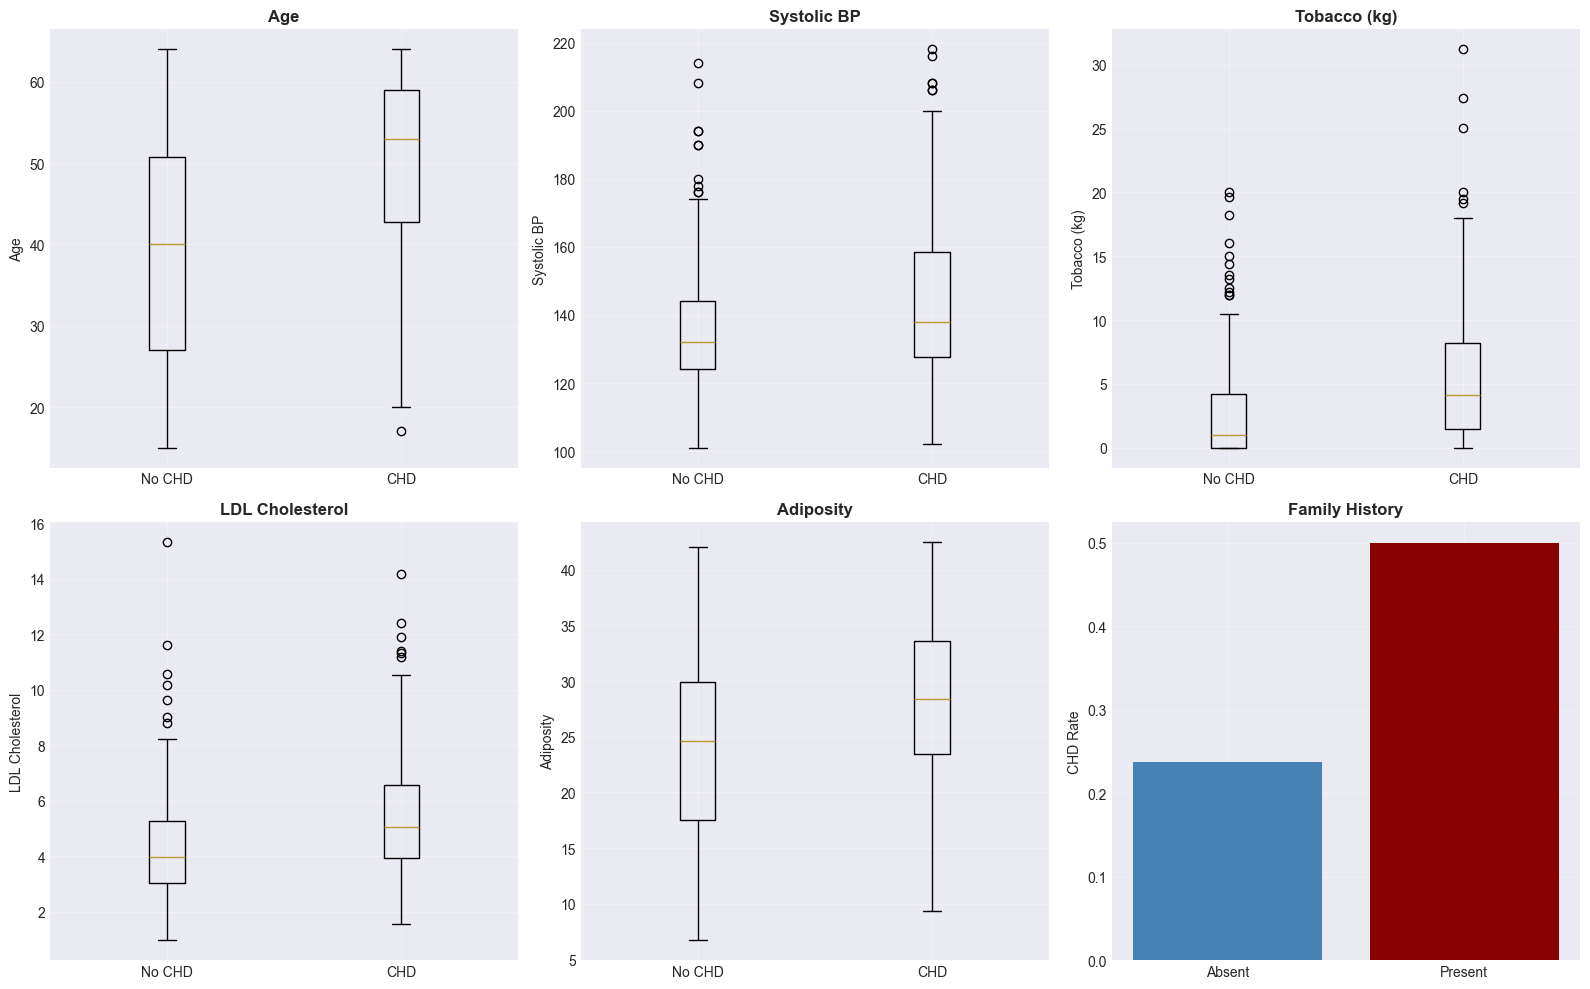

In [15]:
df = pd.read_csv('Heart.csv')
df['famhist'] = (df['famhist'] == 'Present').astype(int)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

risk_factors = ['age', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist']
titles = ['Age', 'Systolic BP', 'Tobacco (kg)', 'LDL Cholesterol', 'Adiposity', 'Family History']

for i, (var, title) in enumerate(zip(risk_factors, titles)):
    if var == 'famhist':
        chd_by_famhist = df.groupby('famhist')['chd'].mean()
        axes[i].bar(['Absent', 'Present'], chd_by_famhist.values, color=['steelblue', 'darkred'])
        axes[i].set_ylabel('CHD Rate', fontsize=10)
    else:
        axes[i].boxplot([df[df['chd'] == 0][var], df[df['chd'] == 1][var]], 
                       labels=['No CHD', 'CHD'])
        axes[i].set_ylabel(title, fontsize=10)
    
    axes[i].set_title(title, fontweight='bold')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Baseline: Logistic Regression

First, fit standard logistic regression for comparison:

$$\log\left(\frac{P(\text{CHD}=1)}{P(\text{CHD}=0)}\right) = \beta_0 + \sum_{j=1}^{p} \beta_j X_j$$

In [16]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred_proba_train_lr = lr.predict_proba(X_train)[:, 1]
y_pred_proba_test_lr = lr.predict_proba(X_test)[:, 1]

train_metrics_lr = classification_metrics(y_train, y_pred_proba_train_lr)
test_metrics_lr = classification_metrics(y_test, y_pred_proba_test_lr)

print("Logistic Regression Results:")
print("=" * 60)
print(f"Training: AUC = {train_metrics_lr['auc_roc']:.3f}, Acc = {train_metrics_lr['accuracy']:.3f}")
print(f"Test:     AUC = {test_metrics_lr['auc_roc']:.3f}, Acc = {test_metrics_lr['accuracy']:.3f}")
print(f"\nTest Performance:")
print(f"  Precision: {test_metrics_lr['precision']:.3f}")
print(f"  Recall:    {test_metrics_lr['recall']:.3f}")
print(f"  F1-score:  {test_metrics_lr['f1_score']:.3f}")

print(f"\nCoefficients (Log-Odds):")
for i, feat in enumerate(features['feature']):
    direction = "↑" if lr.coef_[0][i] > 0 else "↓"
    print(f"  {feat:12s}: {lr.coef_[0][i]:7.3f}  {direction} risk")
print(f"  Intercept:   {lr.intercept_[0]:7.3f}")

Logistic Regression Results:
Training: AUC = 0.789, Acc = 0.751
Test:     AUC = 0.818, Acc = 0.742

Test Performance:
  Precision: 0.625
  Recall:    0.625
  F1-score:  0.625

Coefficients (Log-Odds):
  sbp         :   0.141  ↑ risk
  tobacco     :   0.317  ↑ risk
  ldl         :   0.395  ↑ risk
  adiposity   :  -0.115  ↓ risk
  typea       :   0.363  ↑ risk
  obesity     :  -0.011  ↓ risk
  alcohol     :  -0.046  ↓ risk
  age         :   0.716  ↑ risk
  famhist     :   0.437  ↑ risk
  Intercept:    -0.857


## Logistic GAM

### Model Specification

We'll fit a Logistic GAM with:
- **Smooth terms**: Age, SBP, Tobacco, LDL (using P-splines with 8 knots)
- **Linear term**: Family history (binary variable)
- **Smoothing parameter**: λ = 1.0

$$\log\left(\frac{P(\text{CHD}=1)}{1-P(\text{CHD}=1)}\right) = \beta_0 + f_1(\text{Age}) + f_2(\text{SBP}) + f_3(\text{Tobacco}) + f_4(\text{LDL}) + \beta_5 \cdot \text{FamHist}$$

The IRLS algorithm with backfitting ensures convergence to the maximum likelihood solution.

In [17]:
gam = LogisticGAM(
    smooth_features=[8, 0, 1, 2],
    linear_features=[4],
    n_knots=[8, 8, 8, 8],
    lambda_=[1.0, 1.0, 1.0, 1.0],
    degree=3,
    max_iter=25,
    tol=1e-4
)

print("Fitting LogisticGAM...\n")
gam.fit(X_train, y_train, verbose=True)

y_pred_proba_train_gam = gam.predict_proba(X_train)
y_pred_proba_test_gam = gam.predict_proba(X_test)

train_metrics_gam = classification_metrics(y_train, y_pred_proba_train_gam)
test_metrics_gam = classification_metrics(y_test, y_pred_proba_test_gam)

print("\n" + "=" * 60)
print("LogisticGAM Results:")
print("=" * 60)
print(f"Training: AUC = {train_metrics_gam['auc_roc']:.3f}, Acc = {train_metrics_gam['accuracy']:.3f}")
print(f"Test:     AUC = {test_metrics_gam['auc_roc']:.3f}, Acc = {test_metrics_gam['accuracy']:.3f}")
print(f"\nTest Performance:")
print(f"  Precision: {test_metrics_gam['precision']:.3f}")
print(f"  Recall:    {test_metrics_gam['recall']:.3f}")
print(f"  F1-score:  {test_metrics_gam['f1_score']:.3f}")

Fitting LogisticGAM...

IRLS Iteration 1: Deviance = 476.3761
IRLS Iteration 2: Deviance = 511.5426
IRLS Iteration 3: Deviance = 476.3761
IRLS Iteration 4: Deviance = 513.8746
IRLS Iteration 5: Deviance = 476.4104
IRLS Iteration 6: Deviance = 516.2748
IRLS Iteration 7: Deviance = 476.5124
IRLS Iteration 8: Deviance = 518.7180
IRLS Iteration 9: Deviance = 476.6776
IRLS Iteration 10: Deviance = 521.1666
IRLS Iteration 11: Deviance = 476.8982
IRLS Iteration 12: Deviance = 523.5802
IRLS Iteration 13: Deviance = 477.1634
IRLS Iteration 14: Deviance = 525.9178
IRLS Iteration 15: Deviance = 477.4604
IRLS Iteration 16: Deviance = 528.1409
IRLS Iteration 17: Deviance = 477.7756
IRLS Iteration 18: Deviance = 530.2164
IRLS Iteration 19: Deviance = 478.0957
IRLS Iteration 20: Deviance = 532.1191
IRLS Iteration 21: Deviance = 478.4088
IRLS Iteration 22: Deviance = 533.8324
IRLS Iteration 23: Deviance = 478.7053
IRLS Iteration 24: Deviance = 535.3494
IRLS Iteration 25: Deviance = 478.9783

LogisticG

## Model Comparison

Compare Logistic Regression vs Logistic GAM.

In [18]:
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Logistic GAM'],
    'Train AUC': [train_metrics_lr['auc_roc'], train_metrics_gam['auc_roc']],
    'Test AUC': [test_metrics_lr['auc_roc'], test_metrics_gam['auc_roc']],
    'Test Precision': [test_metrics_lr['precision'], test_metrics_gam['precision']],
    'Test Recall': [test_metrics_lr['recall'], test_metrics_gam['recall']],
    'Test F1': [test_metrics_lr['f1_score'], test_metrics_gam['f1_score']],
    'Effective DF': [10, gam.summary()['total_edf']]
})

print("\nModel Comparison:")
print("=" * 90)
print(comparison.to_string(index=False))

if test_metrics_gam['auc_roc'] > test_metrics_lr['auc_roc']:
    improvement = test_metrics_gam['auc_roc'] - test_metrics_lr['auc_roc']
    print(f"LogisticGAM improves test AUC by {improvement:.3f} points")
else:
    print("Logistic regression is competitive (risk may be approximately linear)")

if test_metrics_gam['recall'] > test_metrics_lr['recall']:
    print(f"LogisticGAM has higher recall ({test_metrics_gam['recall']:.3f}): better at identifying CHD cases")

print(f"LogisticGAM uses {gam.summary()['total_edf']:.1f} effective DF (vs 10 for logistic regression)")


Model Comparison:
              Model  Train AUC  Test AUC  Test Precision  Test Recall  Test F1  Effective DF
Logistic Regression   0.789127  0.817623        0.625000      0.62500  0.62500      10.00000
       Logistic GAM   0.768769  0.715932        0.490196      0.78125  0.60241      24.82699
Logistic regression is competitive (risk may be approximately linear)
LogisticGAM has higher recall (0.781): better at identifying CHD cases
LogisticGAM uses 24.8 effective DF (vs 10 for logistic regression)


## Model Interpretation: Smooth Risk Functions

Visualize smooth functions on the **log-odds scale** to understand how each risk factor affects CHD probability.

In [19]:
summary = gam.summary()

print("LogisticGAM Model Summary:")
print("=" * 60)
print(f"Intercept (log-odds): {summary['intercept']:.3f}")
print(f"Total Effective DF: {summary['total_edf']:.1f}\n")

print("Smooth Terms (Log-Odds Scale):")
smooth_indices = [8, 0, 1, 2]
smooth_names = ['age', 'sbp', 'tobacco', 'ldl']
for feat_idx, name in zip(smooth_indices, smooth_names):
    info = summary['smooth_terms'][feat_idx]
    print(f"  {name:10s}: edf = {info['edf']:.2f}, λ = {info['lambda']}")

print("\nLinear Terms:")
for feat_idx, info in summary['linear_terms'].items():
    feat_name = features['feature'].values[feat_idx]
    print(f"  {feat_name:10s}: coef = {info['coefficient']:.3f} (log-odds)")
    or_value = np.exp(info['coefficient'])
    print(f"                 OR = {or_value:.2f} (odds ratio)")

LogisticGAM Model Summary:
Intercept (log-odds): 0.192
Total Effective DF: 24.8

Smooth Terms (Log-Odds Scale):
  age       : edf = 2.00, λ = 1.0
  sbp       : edf = 7.37, λ = 1.0
  tobacco   : edf = 6.58, λ = 1.0
  ldl       : edf = 6.88, λ = 1.0

Linear Terms:
  typea     : coef = 5.881 (log-odds)
                 OR = 358.15 (odds ratio)


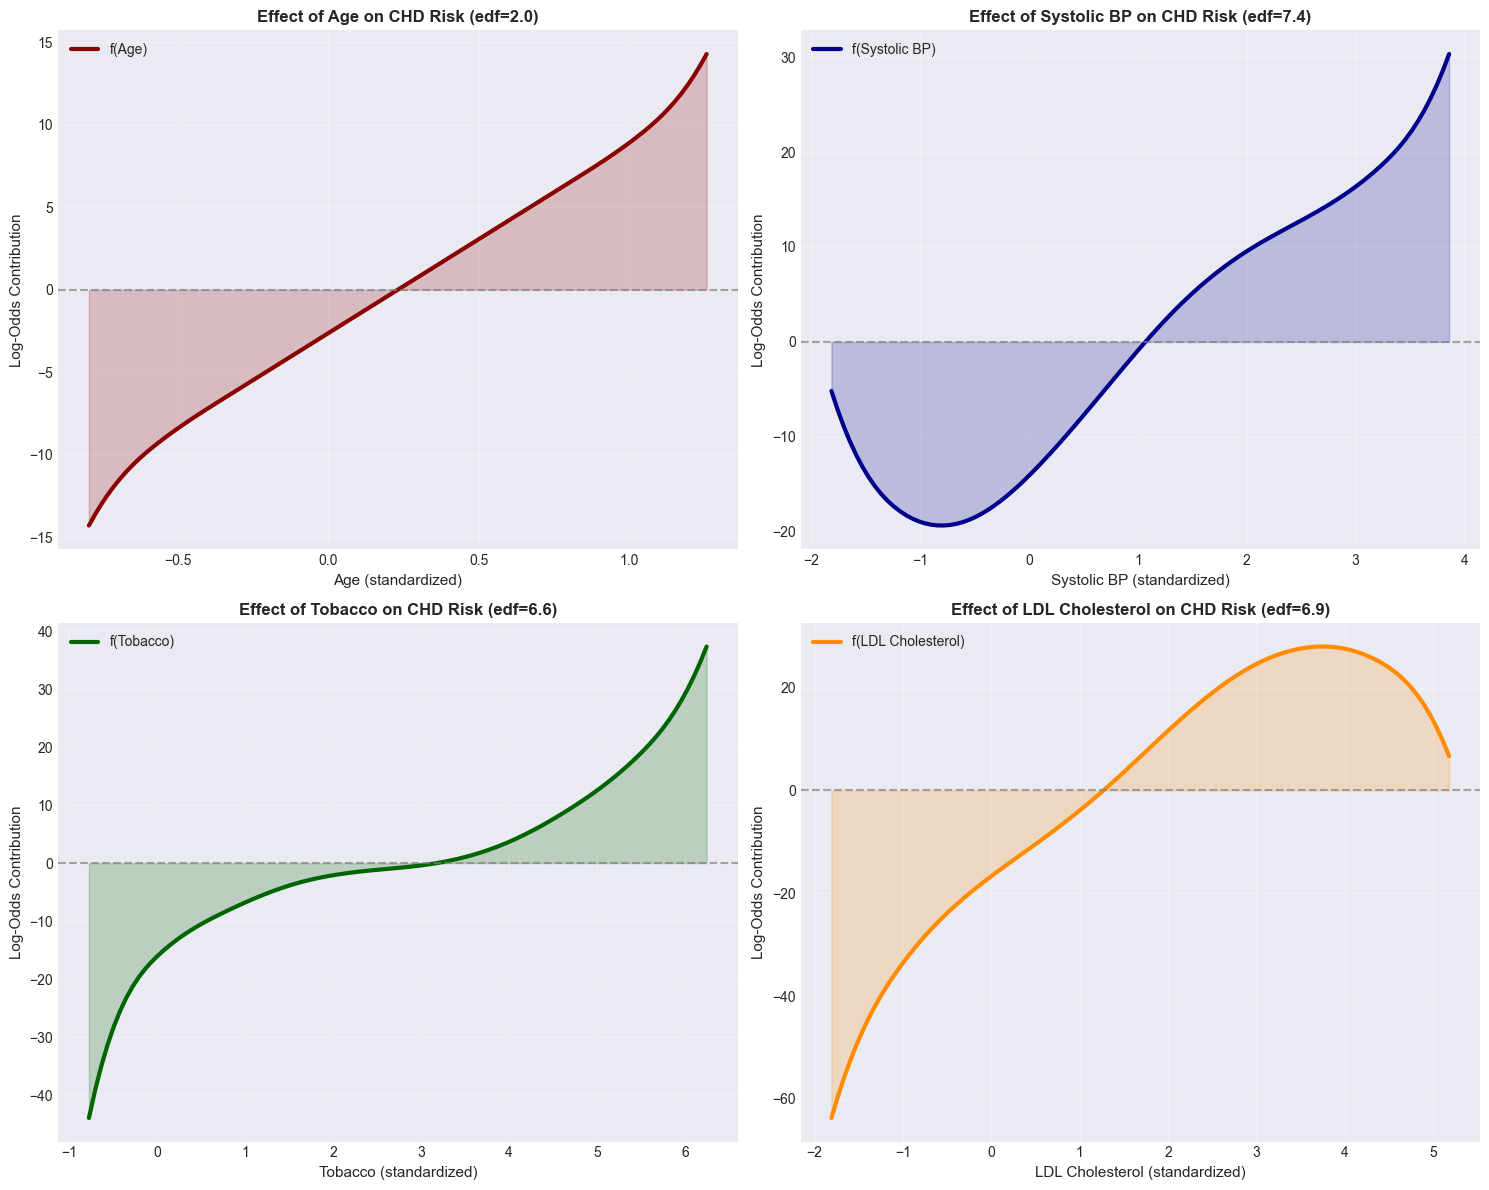

Age: Approximately linear effect (edf=2.0
Systolic BP: Non-linear risk pattern (edf=7.4)
Tobacco: Non-linear risk pattern (edf=6.6)
LDL Cholesterol: Non-linear risk pattern (edf=6.9)


In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

smooth_features = [8, 0, 1, 2]
feature_names = ['Age', 'Systolic BP', 'Tobacco', 'LDL Cholesterol']
colors = ['darkred', 'darkblue', 'darkgreen', 'darkorange']

for i, (feat_idx, name, color) in enumerate(zip(smooth_features, feature_names, colors)):
    x_vals, f_vals = gam.get_smooth_function(feat_idx, n_points=100)
    
    axes[i].plot(x_vals, f_vals, linewidth=3, color=color, label=f'f({name})')
    axes[i].axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    axes[i].fill_between(x_vals, 0, f_vals, alpha=0.2, color=color)
    
    axes[i].set_xlabel(f'{name} (standardized)', fontsize=11)
    axes[i].set_ylabel('Log-Odds Contribution', fontsize=11)
    axes[i].set_title(f'Effect of {name} on CHD Risk (edf={summary["smooth_terms"][feat_idx]["edf"]:.1f})', 
                      fontsize=12, fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.tight_layout()
plt.show()

for feat_idx, name in zip(smooth_features, feature_names):
    edf = summary['smooth_terms'][feat_idx]['edf']
    if edf > 2:
        print(f"{name}: Non-linear risk pattern (edf={edf:.1f})")
    else:
        print(f"{name}: Approximately linear effect (edf={edf:.1f}")

## Classification Performance Diagnostics

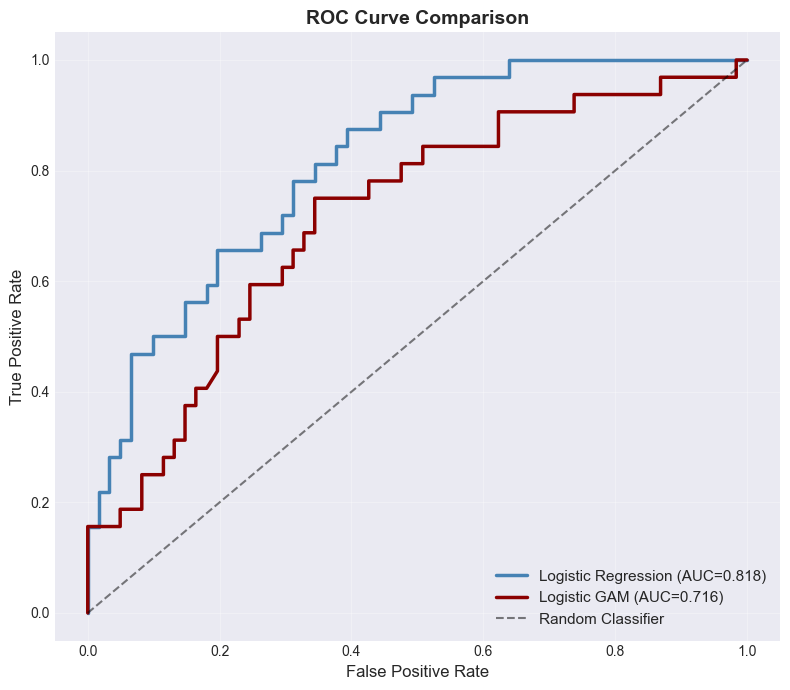

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_test_lr)
auc_lr = test_metrics_lr['auc_roc']
ax.plot(fpr_lr, tpr_lr, linewidth=2.5, label=f'Logistic Regression (AUC={auc_lr:.3f})', color='steelblue')

fpr_gam, tpr_gam, _ = roc_curve(y_test, y_pred_proba_test_gam)
auc_gam = test_metrics_gam['auc_roc']
ax.plot(fpr_gam, tpr_gam, linewidth=2.5, label=f'Logistic GAM (AUC={auc_gam:.3f})', color='darkred')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.5)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

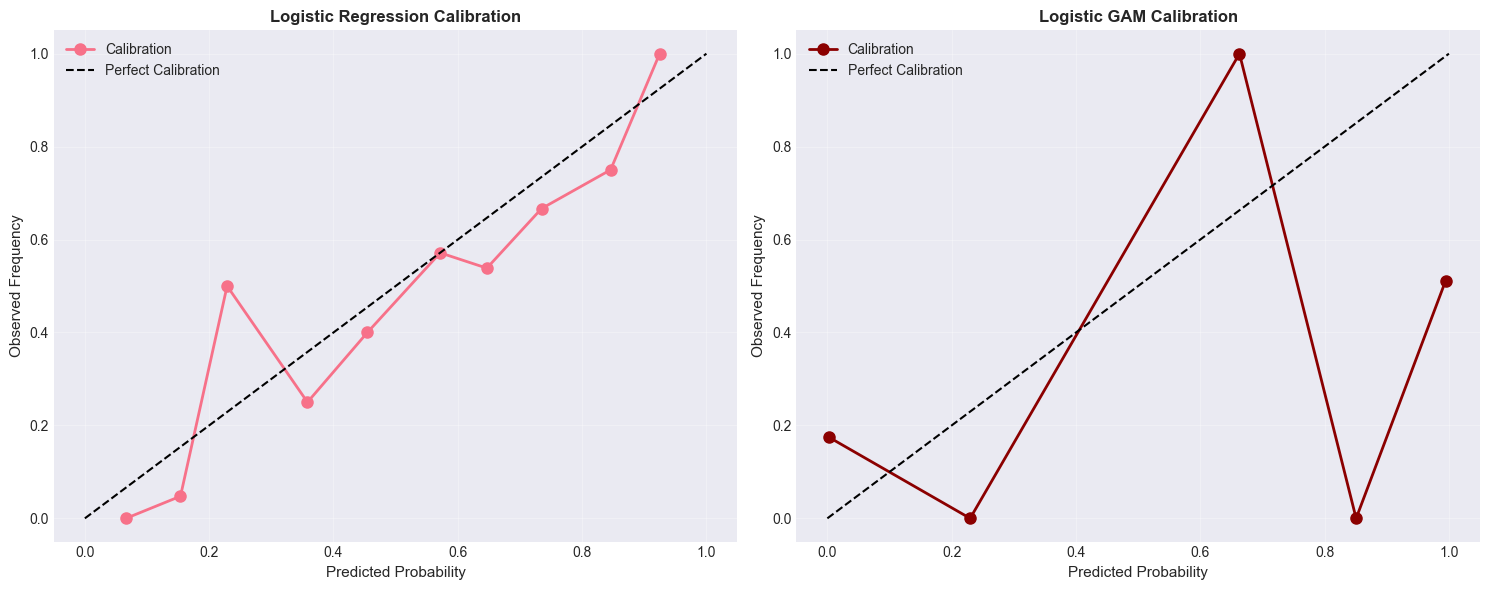

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

from sklearn.calibration import calibration_curve
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_pred_proba_test_lr, n_bins=10)
axes[0].plot(prob_pred_lr, prob_true_lr, 'o-', linewidth=2, markersize=8, label='Calibration')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
axes[0].set_xlabel('Predicted Probability', fontsize=11)
axes[0].set_ylabel('Observed Frequency', fontsize=11)
axes[0].set_title('Logistic Regression Calibration', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

prob_true_gam, prob_pred_gam = calibration_curve(y_test, y_pred_proba_test_gam, n_bins=10)
axes[1].plot(prob_pred_gam, prob_true_gam, 'o-', linewidth=2, markersize=8, 
             label='Calibration', color='darkred')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
axes[1].set_xlabel('Predicted Probability', fontsize=11)
axes[1].set_ylabel('Observed Frequency', fontsize=11)
axes[1].set_title('Logistic GAM Calibration', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

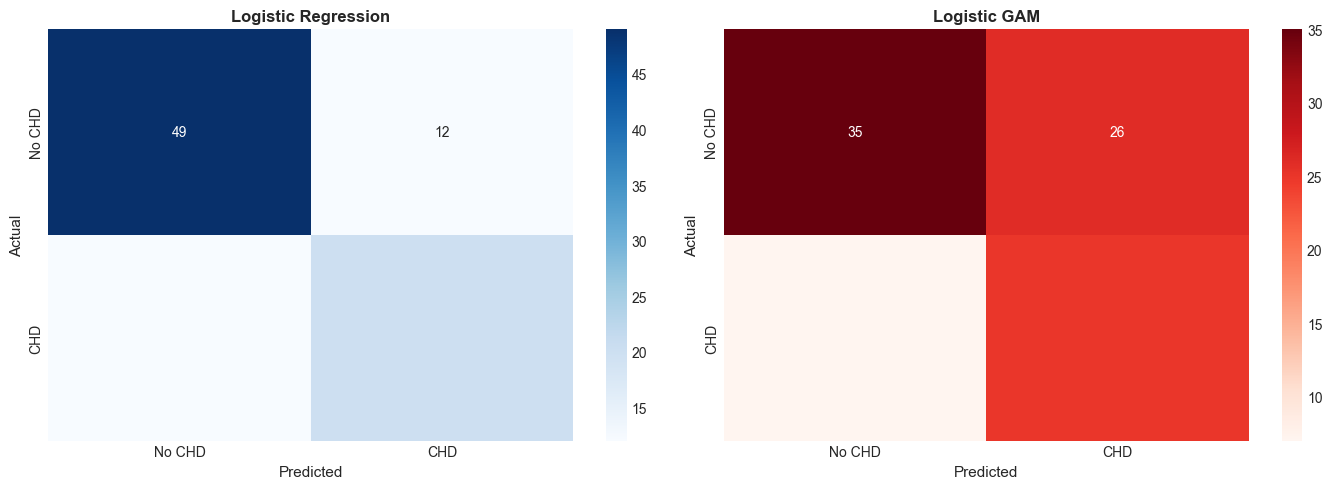


Confusion Matrix Comparison:
Logistic Regression:
  TN=49, FP=12, FN=12, TP=20

Logistic GAM:
  TN=35, FP=26, FN=7, TP=25


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

y_pred_lr = (y_pred_proba_test_lr >= 0.5).astype(int)
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_title('Logistic Regression', fontweight='bold')

y_pred_gam = (y_pred_proba_test_gam >= 0.5).astype(int)
cm_gam = confusion_matrix(y_test, y_pred_gam)
sns.heatmap(cm_gam, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
axes[1].set_xlabel('Predicted', fontsize=11)
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_title('Logistic GAM', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Comparison:")
print("=" * 60)
print("Logistic Regression:")
print(f"  TN={cm_lr[0,0]}, FP={cm_lr[0,1]}, FN={cm_lr[1,0]}, TP={cm_lr[1,1]}")
print(f"\nLogistic GAM:")
print(f"  TN={cm_gam[0,0]}, FP={cm_gam[0,1]}, FN={cm_gam[1,0]}, TP={cm_gam[1,1]}")

## Risk Profiling

Demonstrate how LogisticGAM can be used for individualized risk assessment.

In [24]:
print("Individual Risk Assessment Examples:")
print("=" * 70)

for i in [0, 10, 20]:
    patient_features = X_test[i:i+1]
    true_label = y_test[i]
    
    prob_lr = lr.predict_proba(patient_features)[0, 1]
    prob_gam = gam.predict_proba(patient_features)[0]
    
    print(f"\nPatient {i+1}:")
    print(f"  True Status: {'CHD' if true_label == 1 else 'No CHD'}")
    print(f"  Logistic Regression: {prob_lr:.1%} CHD risk")
    print(f"  Logistic GAM:        {prob_gam:.1%} CHD risk")
    
    if prob_gam < 0.3:
        risk_cat = "Low Risk"
    elif prob_gam < 0.7:
        risk_cat = "Moderate Risk"
    else:
        risk_cat = "High Risk"
    print(f"  Risk Category: {risk_cat}")

Individual Risk Assessment Examples:

Patient 1:
  True Status: CHD
  Logistic Regression: 35.5% CHD risk
  Logistic GAM:        99.8% CHD risk
  Risk Category: High Risk

Patient 11:
  True Status: CHD
  Logistic Regression: 75.2% CHD risk
  Logistic GAM:        3.6% CHD risk
  Risk Category: Low Risk

Patient 21:
  True Status: No CHD
  Logistic Regression: 9.1% CHD risk
  Logistic GAM:        98.9% CHD risk
  Risk Category: High Risk


## Smoothing Parameter Selection

Explore effect of smoothing parameter on model performance.


Smoothing Parameter Comparison:
 Lambda  Test AUC  Effective DF
   0.01  0.715676     35.831938
   0.10  0.711834     31.692224
   1.00  0.715932     24.826990
  10.00  0.730789     18.326652
  50.00  0.731814     14.790240

✓ Optimal λ = 50.0 (maximizes test AUC)


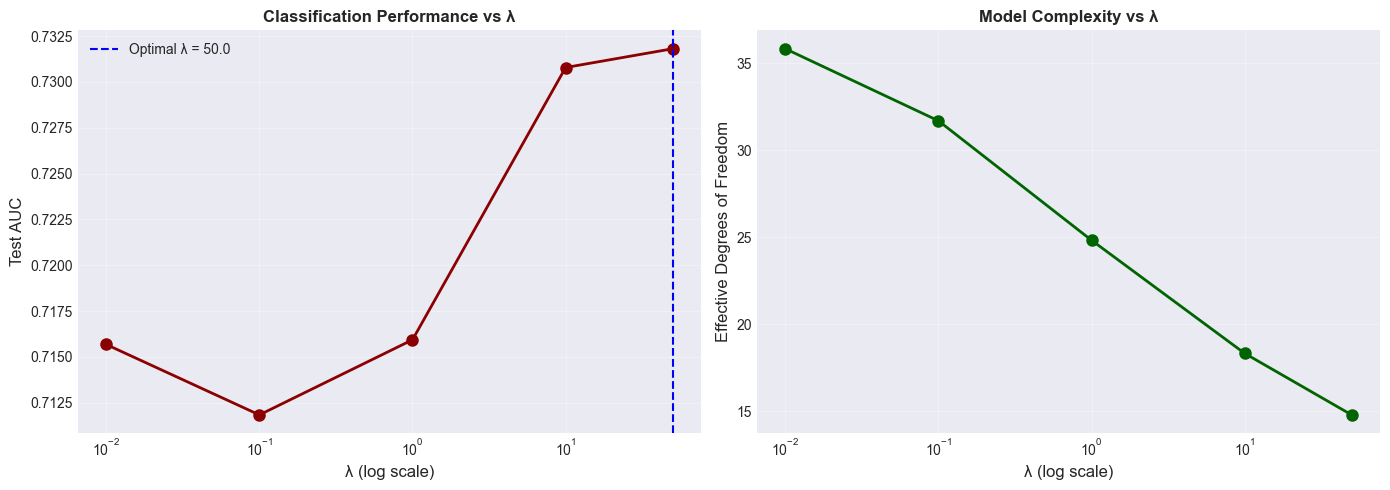

Optimal balance at λ = 50.0


In [25]:
lambdas_to_test = [0.01, 0.1, 1.0, 10.0, 50.0]
results = []

for lam in lambdas_to_test:
    gam_temp = LogisticGAM(
        smooth_features=[8, 0, 1, 2],
        linear_features=[4],
        n_knots=[8, 8, 8, 8],
        lambda_=[lam, lam, lam, lam],
        degree=3,
        max_iter=25,
        tol=1e-4
    )
    gam_temp.fit(X_train, y_train, verbose=False)
    
    y_pred_proba_temp = gam_temp.predict_proba(X_test)
    auc_temp = roc_auc_score(y_test, y_pred_proba_temp)
    edf_temp = gam_temp.summary()['total_edf']
    
    results.append({
        'Lambda': lam,
        'Test AUC': auc_temp,
        'Effective DF': edf_temp
    })

results_df = pd.DataFrame(results)
print("\nSmoothing Parameter Comparison:")
print("=" * 50)
print(results_df.to_string(index=False))

best_idx = results_df['Test AUC'].idxmax()
best_lambda = results_df.loc[best_idx, 'Lambda']
print(f"\n✓ Optimal λ = {best_lambda} (maximizes test AUC)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].semilogx(results_df['Lambda'], results_df['Test AUC'], 'o-', 
                 linewidth=2, markersize=8, color='darkred')
axes[0].axvline(best_lambda, color='blue', linestyle='--', label=f'Optimal λ = {best_lambda}')
axes[0].set_xlabel('λ (log scale)', fontsize=12)
axes[0].set_ylabel('Test AUC', fontsize=12)
axes[0].set_title('Classification Performance vs λ', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].semilogx(results_df['Lambda'], results_df['Effective DF'], 'o-', 
                 linewidth=2, markersize=8, color='darkgreen')
axes[1].set_xlabel('λ (log scale)', fontsize=12)
axes[1].set_ylabel('Effective Degrees of Freedom', fontsize=12)
axes[1].set_title('Model Complexity vs λ', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"Optimal balance at λ = {best_lambda}")